In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import matplotlib.pyplot as plt

In [2]:
from datasets import load_dataset
import numpy as np
import re
from collections import Counter

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [3]:
train_text = train_data["text"]

In [4]:
test_text = test_data["text"]

In [5]:
def preprocess_text(sentences, min_freq=5):
    # Remove non-English characters and words, roman numerals, and less frequent words
    def is_english(word):
        return re.match(r'^[a-zA-Z]+$', word) is not None

    # Tokenizing sentences
    tokenized_sentences = [sentence.lower().split() for sentence in sentences]
    
    # Flatten list and count word frequencies
    all_words = [word for sentence in tokenized_sentences for word in sentence if is_english(word)]
    
    # Remove infrequent words
    word_freq = Counter(all_words)
    vocab = {word for word, freq in word_freq.items() if freq >= min_freq}

    # Add <UNK> token for out-of-vocabulary words
    vocab.add('<UNK>')

    # Filter sentences
    tokenized_sentences = [
        [word if word in vocab else '<UNK>' for word in sentence] 
        for sentence in tokenized_sentences
    ]
    
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}

    return tokenized_sentences, word2idx, idx2word

In [6]:
def generate_cbow_batches(sentences, word2idx, context_size=4, batch_size=32):
    while True:
        batch_targets = []
        batch_contexts = []
        for sentence in sentences:
            sentence_idx = [word2idx[word] for word in sentence]
            for i, target in enumerate(sentence_idx):
                context = sentence_idx[max(0, i-context_size): i] + sentence_idx[i+1: min(len(sentence_idx), i+context_size+1)]
                if len(context) == context_size * 2:
                    batch_targets.append(target)
                    batch_contexts.append(context)
                
                if len(batch_targets) == batch_size:
                    yield np.array(batch_contexts), np.array(batch_targets)
                    batch_targets = []
                    batch_contexts = []

In [7]:
def generate_test_batches(sentences, word2idx, context_size=4, batch_size=32):
    while True:
        batch_targets = []
        batch_contexts = []
        for sentence in sentences:
            sentence_idx = [word2idx.get(word, word2idx['<UNK>']) for word in sentence]
            for i, target in enumerate(sentence_idx):
                context = sentence_idx[max(0, i-context_size): i] + sentence_idx[i+1: min(len(sentence_idx), i+context_size+1)]
                if len(context) == context_size * 2:
                    batch_targets.append(target)
                    batch_contexts.append(context)
                
                if len(batch_targets) == batch_size:
                    yield np.array(batch_contexts), np.array(batch_targets)
                    batch_targets = []
                    batch_contexts = []

In [8]:
class CBOWModel:
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.W1 = np.random.rand(vocab_size, embedding_dim) * 0.01  # Input-Embedding Weights
        self.W2 = np.random.rand(embedding_dim, vocab_size) * 0.01  # Output-Embedding Weights
        # self.context = context
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))
        return exp_z / exp_z.sum(axis=0)
    
    def forward(self, context_words):
        # Mean of context embeddings (CBOW)
        h = np.mean(self.W1[context_words], axis=0)  # shape: (embedding_dim,)
        u = np.dot(h, self.W2)  # shape: (vocab_size,)
        y_pred = self.softmax(u)  # shape: (vocab_size,)
        return y_pred, h
    
    def backward(self, context_words, target_word, y_pred, h, lr=0.01):
        # Compute gradients
        e = y_pred
        e[target_word] -= 1  # Error
        dW2 = np.outer(h, e)  # Gradient of W2
        dW1 = np.mean(np.dot(self.W2, e), axis=0)  # Gradient of W1

        # Update weights
        self.W1[context_words] -= lr * dW1
        self.W2 -= lr * dW2

    def train(self, sentences, word2idx, epochs=10, batch_size=32, context_size=4, lr=0.01):
        num_batches = len(sentences) // batch_size
        generator = generate_cbow_batches(sentences, word2idx, context_size, batch_size)
        
        for epoch in range(epochs):
            total_loss = 0
            for _ in range(num_batches):
                contexts, targets = next(generator)
                batch_loss = 0
                
                for i in range(batch_size):
                    y_pred, h = self.forward(contexts[i])
                    target_word = targets[i]
                    
                    # Calculate loss (cross-entropy)
                    batch_loss -= np.log(y_pred[target_word])
                    
                    # Backpropagation
                    self.backward(contexts[i], target_word, y_pred, h, lr)
                
                total_loss += batch_loss

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/num_batches}")

In [9]:
def mean_reciprocal_rank(predictions, targets):

    reciprocal_ranks = []
    
    for i in range(len(predictions)):
        # Get predicted probabilities for the current query
        pred_probs = predictions[i]
        
        # Sort predictions in descending order and get the indices
        sorted_indices = np.argsort(-pred_probs)
        
        # Find the rank of the true target word
        target_index = targets[i]
        rank = np.where(sorted_indices == target_index)[0][0] + 1  # +1 because rank starts from 1
        
        # Calculate reciprocal rank
        reciprocal_rank = 1 / rank
        reciprocal_ranks.append(reciprocal_rank)
    
    # Calculate Mean Reciprocal Rank
    return np.mean(reciprocal_ranks)


def calculate_mrr(model, sentences, word2idx, context_size=4):
    generator = generate_test_batches(sentences, word2idx, context_size, batch_size=1)
    predictions = []
    targets = []
    
    for _ in range(len(sentences)):
        context, target = next(generator)
        y_pred, _ = model.forward(context[0])
        
        # Store prediction and target for MRR calculation
        predictions.append(y_pred)
        targets.append(target[0])
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    # Calculate MRR using the custom function
    return mean_reciprocal_rank(predictions, targets)

In [10]:
sentences_train = train_text[:10000]
sentences_test = test_text[:1000]

In [11]:
sentences_train

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more f

In [12]:
tokenized_train, word2idx, idx2word = preprocess_text(sentences_train)

In [13]:
word2idx

{'settle': 0,
 'conception': 1,
 'ward': 2,
 'album': 3,
 'seem': 4,
 'deemed': 5,
 'frequently': 6,
 'reportedly': 7,
 'income': 8,
 'eventually': 9,
 'swamp': 10,
 'erlewine': 11,
 'prediction': 12,
 'soir': 13,
 'unions': 14,
 'into': 15,
 'train': 16,
 'fought': 17,
 'reviewers': 18,
 'pledged': 19,
 'tracks': 20,
 'degenerated': 21,
 'advertising': 22,
 'compelled': 23,
 'equipped': 24,
 'agriculture': 25,
 'well': 26,
 'parcel': 27,
 'tomb': 28,
 'bunder': 29,
 'autumn': 30,
 'pierre': 31,
 'killer': 32,
 'mosaic': 33,
 'recommendation': 34,
 'impossible': 35,
 'repeatedly': 36,
 'reopened': 37,
 'monroe': 38,
 'surpassed': 39,
 'affair': 40,
 'gratitude': 41,
 'appearances': 42,
 'slave': 43,
 'spores': 44,
 'alternating': 45,
 'associations': 46,
 'headdress': 47,
 'sounds': 48,
 'coin': 49,
 'dispersed': 50,
 'hair': 51,
 'height': 52,
 'geopyxis': 53,
 'zones': 54,
 'downward': 55,
 'has': 56,
 'marc': 57,
 'hemmema': 58,
 'acronym': 59,
 'moreover': 60,
 'graduating': 61,
 '

In [14]:
len(word2idx)

8600

In [15]:
vocab_size = len(word2idx)
embedding_dim = 50  # Example dimension

In [16]:
tokenized_test, _, _ = preprocess_text(sentences_test)

Epoch 1/10, Loss: 512.1398759071012
Epoch 2/10, Loss: 440.1471221108273
Epoch 3/10, Loss: 439.1746537626002
Epoch 4/10, Loss: 436.56330182988194
Epoch 5/10, Loss: 433.88486685984185
Epoch 6/10, Loss: 422.39898040150337
Epoch 7/10, Loss: 424.1133299868612
Epoch 8/10, Loss: 402.1312634496373
Epoch 9/10, Loss: 424.3206758070017
Epoch 10/10, Loss: 404.8188429346648
Window size: 2, Time: 290.18 seconds, MRR: 0.5070
Epoch 1/10, Loss: 500.06605550257734
Epoch 2/10, Loss: 420.88789597979456
Epoch 3/10, Loss: 418.65604501614155
Epoch 4/10, Loss: 420.327955967889
Epoch 5/10, Loss: 417.63768407315246
Epoch 6/10, Loss: 404.5683527244836
Epoch 7/10, Loss: 412.20560212902
Epoch 8/10, Loss: 394.4359728352397
Epoch 9/10, Loss: 411.41622832104446
Epoch 10/10, Loss: 387.76926989054095
Window size: 3, Time: 266.12 seconds, MRR: 0.2158
Epoch 1/10, Loss: 484.6813162347182
Epoch 2/10, Loss: 403.53091894604677
Epoch 3/10, Loss: 402.62940079811705
Epoch 4/10, Loss: 406.09910460318844
Epoch 5/10, Loss: 400.808

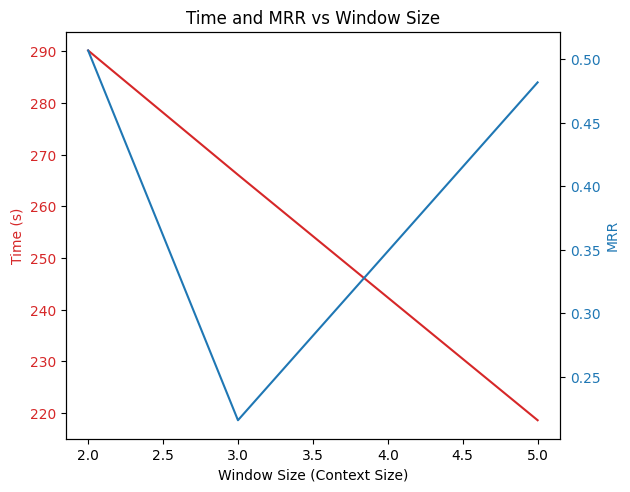

In [17]:
# Variables to store results
window_sizes = [2, 3, 5]  # Different window sizes to test
mrr_scores = []
times_taken = []

# Run the model with different window sizes
for window_size in window_sizes:
    cbow_model = CBOWModel(vocab_size, embedding_dim)

    # Measure time for training
    start_time = time.time()
    cbow_model.train(tokenized_train, word2idx, epochs=10, batch_size=64, context_size=window_size, lr=0.01)
    end_time = time.time()
    
    # Calculate time taken and store it
    time_taken = end_time - start_time
    times_taken.append(time_taken)
    
    # Calculate MRR on test data
    mrr = calculate_mrr(cbow_model, tokenized_test, word2idx)
    mrr_scores.append(mrr)

    print(f"Window size: {window_size}, Time: {time_taken:.2f} seconds, MRR: {mrr:.4f}")


# Plotting Time and MRR vs Window Size
fig, ax1 = plt.subplots()

# Plot Time on left y-axis
ax1.set_xlabel('Window Size (Context Size)')
ax1.set_ylabel('Time (s)', color='tab:red')
ax1.plot(window_sizes, times_taken, color='tab:red', label='Time')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for MRR
ax2 = ax1.twinx()
ax2.set_ylabel('MRR', color='tab:blue')
ax2.plot(window_sizes, mrr_scores, color='tab:blue', label='MRR')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add legends and show the plot
fig.tight_layout()
plt.title("Time and MRR vs Window Size")
plt.show()